# Install libraries

In [2]:
import numpy as np
import torch
import torchvision

print("="*80)
print("ENVIRONMENT CHECK")
print("="*80)
print(f"NumPy version:       {np.__version__}")
print(f"PyTorch version:     {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available:      {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version:        {torch.version.cuda}")
    print(f"GPU:                 {torch.cuda.get_device_name(0)}")
print("\nUsing custom tensor conversion to handle compatibility issues")


ENVIRONMENT CHECK
NumPy version:       1.26.4
PyTorch version:     2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA available:      True
CUDA version:        12.4
GPU:                 Tesla P100-PCIE-16GB

Using custom tensor conversion to handle compatibility issues


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path
from tqdm.auto import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_auc_score, silhouette_score,
    classification_report
)
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("="*80)
print("IMPORTS COMPLETE")
print("="*80)
print(f"Device: {device}")
print("All packages imported successfully")


IMPORTS COMPLETE
Device: cuda
All packages imported successfully


# CELL 3: SSL Components (Projection Head, NT-Xent Loss, Classifiers)

In [4]:
class SimCLRProjectionHead(nn.Module):
    """Projection head for SimCLR"""
    def __init__(self, input_dim=2048, hidden_dim=2048, output_dim=128):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.projection(x)


class NTXentLoss(nn.Module):
    """NT-Xent Loss for SimCLR"""
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
    
    def forward(self, z_i, z_j):
        batch_size = z_i.shape[0]
        
        # Normalize
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)
        
        # Concatenate
        z = torch.cat([z_i, z_j], dim=0)
        
        # Similarity matrix
        similarity_matrix = torch.matmul(z, z.T) / self.temperature
        
        # Mask diagonal
        mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z.device)
        similarity_matrix = similarity_matrix.masked_fill(mask, -1e9)
        
        # Labels for positive pairs
        labels = torch.cat([torch.arange(batch_size, 2*batch_size),
                           torch.arange(0, batch_size)]).to(z.device)
        
        loss = self.criterion(similarity_matrix, labels) / (2 * batch_size)
        return loss


class LinearClassifier(nn.Module):
    """Linear probe classifier"""
    def __init__(self, input_dim=2048, num_classes=38):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return self.linear(x)


class MLPClassifier(nn.Module):
    """MLP classifier"""
    def __init__(self, input_dim=2048, hidden_dim=512, num_classes=38):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, num_classes)
        )
    
    def forward(self, x):
        return self.mlp(x)

print("SSL components defined:")
print("  - SimCLRProjectionHead")
print("  - NTXentLoss")
print("  - LinearClassifier")
print("  - MLPClassifier")


SSL components defined:
  - SimCLRProjectionHead
  - NTXentLoss
  - LinearClassifier
  - MLPClassifier


# CELL 4: Dataset Class with Manual Tensor Conversion

In [5]:
class RiceDataset(Dataset):
    """Rice dataset with numpy compatibility fix"""
    def __init__(self, root_dir, mode='ssl', split_ratio=0.7, train=True, seed=42):
        self.root_dir = Path(root_dir)
        self.mode = mode
        self.train = train
        
        self.image_paths = []
        self.labels = []
        
        self.class_names = sorted([d.name for d in self.root_dir.iterdir() 
                                   if d.is_dir() and not d.name.startswith('.')])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.class_names)}
        self.num_classes = len(self.class_names)
        
        np.random.seed(seed)
        
        for class_name in self.class_names:
            class_dir = self.root_dir / class_name
            class_images = []
            for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
                class_images.extend(list(class_dir.glob(ext)))
            
            class_images = sorted(class_images)
            if len(class_images) == 0:
                print(f"Warning: No images in {class_name}")
                continue
            
            indices = np.arange(len(class_images))
            np.random.shuffle(indices)
            class_images = [class_images[i] for i in indices]
            
            split_idx = int(len(class_images) * split_ratio)
            selected_images = class_images[:split_idx] if train else class_images[split_idx:]
            
            self.image_paths.extend(selected_images)
            self.labels.extend([self.class_to_idx[class_name]] * len(selected_images))
        
        print(f"{'Train' if train else 'Test'} dataset initialized:")
        print(f"  Images: {len(self.image_paths)}")
        print(f"  Classes: {self.num_classes}")
        print(f"  Mode: {mode}")
        
        self._setup_transforms()
    
    def _setup_transforms(self):
        if self.mode == 'ssl':
            self.base_transform = transforms.Compose([
                transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply([
                    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
                ], p=0.8),
                transforms.RandomGrayscale(p=0.2),
                transforms.RandomApply([
                    transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0))
                ], p=0.5)
            ])
        else:
            self.base_transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224)
            ])
        
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    
    def pil_to_tensor_manual(self, pil_img):
        """Manual PIL to tensor conversion - avoids numpy compatibility bug"""
        img_np = np.array(pil_img, dtype='uint8')
        img_np = img_np.astype('float32') / 255.0
        if len(img_np.shape) == 3:
            img_np = np.transpose(img_np, (2, 0, 1))
        elif len(img_np.shape) == 2:
            img_np = np.expand_dims(img_np, axis=0)
        tensor = torch.from_numpy(img_np.copy())
        return tensor
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.mode == 'ssl':
            view1_pil = self.base_transform(image)
            view2_pil = self.base_transform(image)
            view1 = self.pil_to_tensor_manual(view1_pil)
            view2 = self.pil_to_tensor_manual(view2_pil)
            view1 = self.normalize(view1)
            view2 = self.normalize(view2)
            return view1, view2, label
        else:
            img_pil = self.base_transform(image)
            img_tensor = self.pil_to_tensor_manual(img_pil)
            img_tensor = self.normalize(img_tensor)
            return img_tensor, label

print("RiceDataset class defined successfully")
print("Using manual tensor conversion to avoid numpy compatibility issues")


RiceDataset class defined successfully
Using manual tensor conversion to avoid numpy compatibility issues


# CELL 5: Dataset Path Configuration

In [6]:
# Dataset path
DATASET_ROOT = '/kaggle/input/dataset-for-classifying-rice-varieties-in-bd/Rice Varieties in Bangladesh/Original'

print("="*80)
print("DATASET VERIFICATION")
print("="*80)

if not os.path.exists(DATASET_ROOT):
    print(f"ERROR: Dataset not found at {DATASET_ROOT}")
    if os.path.exists('/kaggle/input'):
        print("\nAvailable paths:")
        for item in os.listdir('/kaggle/input'):
            print(f"  - /kaggle/input/{item}")
    raise FileNotFoundError(f"Dataset not found")
else:
    print(f"Dataset path: {DATASET_ROOT}")
    
    classes = sorted([d for d in os.listdir(DATASET_ROOT) 
                     if os.path.isdir(os.path.join(DATASET_ROOT, d)) and not d.startswith('.')])
    num_classes = len(classes)
    
    print(f"Number of classes: {num_classes}")
    print(f"\nFirst 10 rice varieties:")
    for i, cls in enumerate(classes[:10]):
        class_path = os.path.join(DATASET_ROOT, cls)
        num_images = len([f for f in os.listdir(class_path) 
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"  {i+1}. {cls:<20} ({num_images} images)")
    
    total_images = sum(len([f for f in os.listdir(os.path.join(DATASET_ROOT, cls)) 
                           if f.lower().endswith(('.jpg', '.jpeg', '.png'))]) 
                      for cls in classes)
    print(f"\nTotal images: {total_images}")

# Hyperparameters
NUM_CLASSES = 38
BATCH_SIZE = 64
PROJECTION_DIM = 128
HIDDEN_DIM = 2048
TEMPERATURE = 0.5
SSL_EPOCHS = 100
LINEAR_PROBE_EPOCHS = 50
FINETUNE_EPOCHS = 30
LEARNING_RATE = 0.001
SPLIT_RATIO = 0.7

print("\n" + "="*80)
print("HYPERPARAMETERS")
print("="*80)
print(f"Batch size:            {BATCH_SIZE}")
print(f"Projection dim:        {PROJECTION_DIM}")
print(f"Temperature:           {TEMPERATURE}")
print(f"SSL epochs:            {SSL_EPOCHS}")
print(f"Linear probe epochs:   {LINEAR_PROBE_EPOCHS}")
print(f"Fine-tuning epochs:    {FINETUNE_EPOCHS}")
print(f"Learning rate:         {LEARNING_RATE}")
print(f"Split ratio:           {SPLIT_RATIO}")


DATASET VERIFICATION
Dataset path: /kaggle/input/dataset-for-classifying-rice-varieties-in-bd/Rice Varieties in Bangladesh/Original
Number of classes: 38

First 10 rice varieties:
  1. BD30                 (500 images)
  2. BD33                 (500 images)
  3. BD39                 (500 images)
  4. BD49                 (500 images)
  5. BD51                 (500 images)
  6. BD52                 (500 images)
  7. BD56                 (500 images)
  8. BD57                 (500 images)
  9. BD70                 (500 images)
  10. BD72                 (500 images)

Total images: 19000

HYPERPARAMETERS
Batch size:            64
Projection dim:        128
Temperature:           0.5
SSL epochs:            100
Linear probe epochs:   50
Fine-tuning epochs:    30
Learning rate:         0.001
Split ratio:           0.7


# CELL 6: SimCLR Model Definition

In [7]:
class SimCLR(nn.Module):
    """SimCLR model with ResNet50 backbone"""
    def __init__(self, projection_dim=128, hidden_dim=2048):
        super().__init__()
        
        resnet = models.resnet50(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        self.encoder_dim = 2048
        
        self.projection_head = SimCLRProjectionHead(
            input_dim=self.encoder_dim,
            hidden_dim=hidden_dim,
            output_dim=projection_dim
        )
    
    def forward(self, x):
        h = self.encoder(x)
        h = torch.flatten(h, start_dim=1)
        z = self.projection_head(h)
        return h, z

print("="*80)
print("SIMCLR MODEL INITIALIZATION")
print("="*80)

simclr_model = SimCLR(projection_dim=PROJECTION_DIM, hidden_dim=HIDDEN_DIM).to(device)

total_params = sum(p.numel() for p in simclr_model.parameters())
trainable_params = sum(p.numel() for p in simclr_model.parameters() if p.requires_grad)
encoder_params = sum(p.numel() for p in simclr_model.encoder.parameters())
projection_params = sum(p.numel() for p in simclr_model.projection_head.parameters())

print(f"Architecture:           ResNet50 + Projection Head")
print(f"Total parameters:       {total_params:,}")
print(f"Trainable parameters:   {trainable_params:,}")
print(f"Encoder parameters:     {encoder_params:,}")
print(f"Projection parameters:  {projection_params:,}")
print(f"Encoder output dim:     {simclr_model.encoder_dim}")
print(f"Projection output dim:  {PROJECTION_DIM}")
print(f"Device:                 {device}")


SIMCLR MODEL INITIALIZATION


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s]


Architecture:           ResNet50 + Projection Head
Total parameters:       27,966,656
Trainable parameters:   27,966,656
Encoder parameters:     23,508,032
Projection parameters:  4,458,624
Encoder output dim:     2048
Projection output dim:  128
Device:                 cuda


# CELL 7: SimCLR Pretraining - Label-Free

In [8]:
print("="*80)
print("SIMCLR PRETRAINING - OPTIMIZED FOR TIME (50 EPOCHS)")
print("="*80)

ssl_train_dataset = RiceDataset(
    root_dir=DATASET_ROOT,
    mode='ssl',
    split_ratio=SPLIT_RATIO,
    train=True,
    seed=42
)

ssl_train_loader = DataLoader(
    ssl_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    drop_last=True
)

print(f"DataLoader: {len(ssl_train_loader)} batches, {len(ssl_train_dataset)} samples")

criterion = NTXentLoss(temperature=TEMPERATURE).to(device)
optimizer = torch.optim.Adam(simclr_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

# Reduced epochs for faster training
REDUCED_SSL_EPOCHS = 50

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=REDUCED_SSL_EPOCHS)

ssl_history = {
    'epoch': [],
    'loss': [],
    'learning_rate': [],
    'time': []
}

print(f"\nStarting optimized pretraining (50 instead of 100 epochs)...")
print(f"Expected time: ~10-11 hours")

simclr_model.train()
global_start_time = time.time()

for epoch in range(REDUCED_SSL_EPOCHS):
    epoch_start = time.time()
    running_loss = 0.0
    num_batches = 0
    
    progress_bar = tqdm(ssl_train_loader, desc=f"Epoch {epoch+1}/{REDUCED_SSL_EPOCHS}")
    
    for batch_idx, (view1, view2, _) in enumerate(progress_bar):
        view1 = view1.to(device, non_blocking=True)
        view2 = view2.to(device, non_blocking=True)
        
        _, z_i = simclr_model(view1)
        _, z_j = simclr_model(view2)
        
        loss = criterion(z_i, z_j)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        num_batches += 1
        
        progress_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'avg_loss': f"{running_loss/num_batches:.4f}"
        })
    
    scheduler.step()
    
    epoch_loss = running_loss / num_batches
    epoch_time = time.time() - epoch_start
    
    ssl_history['epoch'].append(epoch + 1)
    ssl_history['loss'].append(epoch_loss)
    ssl_history['learning_rate'].append(optimizer.param_groups[0]['lr'])
    ssl_history['time'].append(epoch_time)
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        elapsed = time.time() - global_start_time
        remaining = (elapsed / (epoch + 1)) * (REDUCED_SSL_EPOCHS - epoch - 1)
        print(f"\nEpoch {epoch+1}/{REDUCED_SSL_EPOCHS}")
        print(f"  Loss: {epoch_loss:.4f}")
        print(f"  Time: {epoch_time:.2f}s")
        print(f"  Elapsed: {elapsed/3600:.1f}h | Remaining: {remaining/3600:.1f}h")

total_training_time = time.time() - global_start_time

print("\n" + "="*80)
print("PRETRAINING COMPLETED")
print("="*80)
print(f"Total time: {total_training_time/3600:.2f} hours")
print(f"Final loss: {ssl_history['loss'][-1]:.4f}")
print(f"Avg epoch time: {np.mean(ssl_history['time']):.2f}s")

torch.save({
    'epoch': REDUCED_SSL_EPOCHS,
    'encoder_state_dict': simclr_model.encoder.state_dict(),
    'projection_head_state_dict': simclr_model.projection_head.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'ssl_history': ssl_history,
    'hyperparameters': {
        'batch_size': BATCH_SIZE,
        'projection_dim': PROJECTION_DIM,
        'temperature': TEMPERATURE,
        'learning_rate': LEARNING_RATE,
        'epochs': REDUCED_SSL_EPOCHS
    }
}, 'simclr_pretrained_encoder.pth')

print("Saved: simclr_pretrained_encoder.pth")


SIMCLR PRETRAINING - OPTIMIZED FOR TIME (50 EPOCHS)
Train dataset initialized:
  Images: 13300
  Classes: 38
  Mode: ssl
DataLoader: 207 batches, 13300 samples

Starting optimized pretraining (50 instead of 100 epochs)...
Expected time: ~10-11 hours


Epoch 1/50:   0%|          | 0/207 [00:00<?, ?it/s]


Epoch 1/50
  Loss: 3.7250
  Time: 770.45s
  Elapsed: 0.2h | Remaining: 10.5h


Epoch 2/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/207 [00:00<?, ?it/s]


Epoch 5/50
  Loss: 3.3708
  Time: 639.20s
  Elapsed: 0.9h | Remaining: 8.4h


Epoch 6/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/207 [00:00<?, ?it/s]


Epoch 10/50
  Loss: 3.2552
  Time: 650.91s
  Elapsed: 1.8h | Remaining: 7.4h


Epoch 11/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/207 [00:00<?, ?it/s]


Epoch 15/50
  Loss: 3.2053
  Time: 641.48s
  Elapsed: 2.7h | Remaining: 6.4h


Epoch 16/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/207 [00:00<?, ?it/s]


Epoch 20/50
  Loss: 3.1701
  Time: 656.95s
  Elapsed: 3.6h | Remaining: 5.5h


Epoch 21/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/207 [00:00<?, ?it/s]


Epoch 25/50
  Loss: 3.1394
  Time: 677.64s
  Elapsed: 4.6h | Remaining: 4.6h


Epoch 26/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/207 [00:00<?, ?it/s]


Epoch 30/50
  Loss: 3.1118
  Time: 667.31s
  Elapsed: 5.5h | Remaining: 3.7h


Epoch 31/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/207 [00:00<?, ?it/s]


Epoch 35/50
  Loss: 3.0965
  Time: 684.45s
  Elapsed: 6.5h | Remaining: 2.8h


Epoch 36/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/207 [00:00<?, ?it/s]


Epoch 40/50
  Loss: 3.0784
  Time: 680.13s
  Elapsed: 7.4h | Remaining: 1.9h


Epoch 41/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/207 [00:00<?, ?it/s]


Epoch 45/50
  Loss: 3.0705
  Time: 686.49s
  Elapsed: 8.4h | Remaining: 0.9h


Epoch 46/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/207 [00:00<?, ?it/s]


Epoch 50/50
  Loss: 3.0645
  Time: 683.31s
  Elapsed: 9.3h | Remaining: 0.0h

PRETRAINING COMPLETED
Total time: 9.33 hours
Final loss: 3.0645
Avg epoch time: 671.99s
Saved: simclr_pretrained_encoder.pth


# CELL 8: Feature Extraction from Frozen Encoder

In [9]:
print("="*80)
print("FEATURE EXTRACTION - DOWNSTREAM PREPARATION")
print("="*80)

def extract_features(model, data_loader, device):
    """Extract features from frozen encoder"""
    model.eval()
    features_list = []
    labels_list = []
    
    with torch.no_grad():
        for images, lbls in tqdm(data_loader, desc="Extracting features"):
            images = images.to(device, non_blocking=True)
            h, _ = model(images)  # Extract features (not projections)
            features_list.append(h.cpu())
            labels_list.append(lbls)
    
    features = torch.cat(features_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    return features, labels

# Create evaluation datasets
eval_train_dataset = RiceDataset(
    root_dir=DATASET_ROOT,
    mode='eval',
    split_ratio=SPLIT_RATIO,
    train=True,
    seed=42
)
eval_test_dataset = RiceDataset(
    root_dir=DATASET_ROOT,
    mode='eval',
    split_ratio=SPLIT_RATIO,
    train=False,
    seed=42
)
eval_train_loader = DataLoader(eval_train_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0, pin_memory=True)
eval_test_loader = DataLoader(eval_test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0, pin_memory=True)

# Freeze encoder
for param in simclr_model.encoder.parameters():
    param.requires_grad = False
simclr_model.eval()

# Extract features
print("\nExtracting train features...")
train_features, train_labels = extract_features(simclr_model, eval_train_loader, device)
print("Extracting test features...")
test_features, test_labels = extract_features(simclr_model, eval_test_loader, device)

print(f"\nTrain features: {train_features.shape}")
print(f"Test features:  {test_features.shape}")

# Save features
torch.save({'train_features': train_features, 'train_labels': train_labels,
            'test_features': test_features,  'test_labels': test_labels,
            'class_names': eval_train_dataset.class_names}, 'simclr_features.pth')
print("Saved features to simclr_features.pth")


FEATURE EXTRACTION - DOWNSTREAM PREPARATION
Train dataset initialized:
  Images: 13300
  Classes: 38
  Mode: eval
Test dataset initialized:
  Images: 5700
  Classes: 38
  Mode: eval

Extracting train features...


Extracting features:   0%|          | 0/104 [00:00<?, ?it/s]

Extracting test features...


Extracting features:   0%|          | 0/45 [00:00<?, ?it/s]


Train features: torch.Size([13300, 2048])
Test features:  torch.Size([5700, 2048])
Saved features to simclr_features.pth


# CELL 9: Linear Probe Evaluation

In [10]:
print("="*80)
print("LINEAR PROBE EVALUATION")
print("="*80)

class FeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

feature_train_dataset = FeatureDataset(train_features, train_labels)
feature_test_dataset = FeatureDataset(test_features, test_labels)

feature_train_loader = DataLoader(feature_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
feature_test_loader  = DataLoader(feature_test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

# Linear classifier
linear_classifier = LinearClassifier(input_dim=2048, num_classes=NUM_CLASSES).to(device)
criterion_ce = nn.CrossEntropyLoss()
optimizer_linear = torch.optim.Adam(linear_classifier.parameters(), lr=0.001)

linear_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
print("Training linear probe...")
for epoch in range(LINEAR_PROBE_EPOCHS):
    # Train
    linear_classifier.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for features, labels in feature_train_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = linear_classifier(features)
        loss = criterion_ce(outputs, labels)
        optimizer_linear.zero_grad()
        loss.backward()
        optimizer_linear.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    train_loss /= len(feature_train_loader)
    train_acc  = 100. * train_correct / train_total
    linear_history['train_loss'].append(train_loss)
    linear_history['train_acc'].append(train_acc)
    # Validate
    linear_classifier.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for features, labels in feature_test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = linear_classifier(features)
            loss = criterion_ce(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    val_loss /= len(feature_test_loader)
    val_acc  = 100. * val_correct / val_total
    linear_history['val_loss'].append(val_loss)
    linear_history['val_acc'].append(val_acc)
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{LINEAR_PROBE_EPOCHS}: Train Acc={train_acc:.2f}% Val Acc={val_acc:.2f}%")
print(f"\nFinal Linear Probe Test Accuracy: {val_acc:.2f}%")

torch.save(linear_classifier.state_dict(), 'linear_classifier.pth')


LINEAR PROBE EVALUATION
Training linear probe...
Epoch 10/50: Train Acc=41.57% Val Acc=39.32%
Epoch 20/50: Train Acc=48.08% Val Acc=45.68%
Epoch 30/50: Train Acc=51.32% Val Acc=47.95%
Epoch 40/50: Train Acc=53.60% Val Acc=49.81%
Epoch 50/50: Train Acc=55.38% Val Acc=50.93%

Final Linear Probe Test Accuracy: 50.93%


# CELL 10: Detailed Metrics for Linear Probe

In [11]:
print("="*80)
print("LINEAR PROBE METRICS & REPORT")
print("="*80)

# Get predictions
linear_classifier.eval()
all_preds, all_labels, all_probs = [], [], []
with torch.no_grad():
    for features, labels in feature_test_loader:
        features = features.to(device)
        outputs = linear_classifier(features)
        probs = F.softmax(outputs, dim=1)
        all_probs.append(probs.cpu())
        all_preds.append(outputs.argmax(dim=1).cpu())
        all_labels.append(labels)
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()
all_probs = torch.cat(all_probs).numpy()

accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)
per_class_report = classification_report(all_labels, all_preds, target_names=eval_test_dataset.class_names, zero_division=0, output_dict=True)
y_test_bin = label_binarize(all_labels, classes=np.arange(NUM_CLASSES))
roc_auc = roc_auc_score(y_test_bin, all_probs, average='weighted', multi_class='ovr')

print(f"Accuracy:  {accuracy*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

linear_probe_metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'roc_auc': roc_auc,
    'per_class_report': per_class_report,
    'confusion_matrix': confusion_matrix(all_labels, all_preds)
}


LINEAR PROBE METRICS & REPORT
Accuracy:  50.93%
Precision: 0.5285
Recall:    0.5093
F1-score:  0.4930
ROC-AUC:   0.9644


# CELL 12: Fine-Tuning Full Encoder

In [12]:
print("="*80)
print("FULL FINE-TUNING")
print("="*80)

simclr_finetune = SimCLR(projection_dim=PROJECTION_DIM, hidden_dim=HIDDEN_DIM).to(device)
checkpoint = torch.load('simclr_pretrained_encoder.pth')
simclr_finetune.encoder.load_state_dict(checkpoint['encoder_state_dict'])
simclr_finetune.projection_head = nn.Linear(2048, NUM_CLASSES).to(device)

for param in simclr_finetune.parameters():
    param.requires_grad = True

optimizer_finetune = torch.optim.Adam(simclr_finetune.parameters(), lr=0.0001)
scheduler_finetune = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_finetune, T_max=FINETUNE_EPOCHS)

finetune_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
print("Fine-tuning full model...")
for epoch in range(FINETUNE_EPOCHS):
    # Train
    simclr_finetune.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for images, labels in tqdm(eval_train_loader, desc=f"Epoch {epoch+1}/{FINETUNE_EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        h, logits = simclr_finetune(images)
        loss = criterion_ce(logits, labels)
        optimizer_finetune.zero_grad()
        loss.backward()
        optimizer_finetune.step()
        train_loss += loss.item()
        _, predicted = logits.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    train_loss /= len(eval_train_loader)
    train_acc  = 100. * train_correct / train_total
    # Validate
    simclr_finetune.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in eval_test_loader:
            images, labels = images.to(device), labels.to(device)
            h, logits = simclr_finetune(images)
            loss = criterion_ce(logits, labels)
            val_loss += loss.item()
            _, predicted = logits.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    val_loss /= len(eval_test_loader)
    val_acc  = 100. * val_correct / val_total
    finetune_history['train_loss'].append(train_loss)
    finetune_history['train_acc'].append(train_acc)
    finetune_history['val_loss'].append(val_loss)
    finetune_history['val_acc'].append(val_acc)
    scheduler_finetune.step()
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{FINETUNE_EPOCHS}: Train Acc={train_acc:.2f}% Val Acc={val_acc:.2f}%")

print(f"\nFinal Fine-Tuned Test Accuracy: {val_acc:.2f}%")
torch.save(simclr_finetune.state_dict(), 'simclr_finetuned.pth')


FULL FINE-TUNING
Fine-tuning full model...


Epoch 1/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 5/30: Train Acc=0.46% Val Acc=2.28%


Epoch 6/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 10/30: Train Acc=0.61% Val Acc=2.14%


Epoch 11/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 15/30: Train Acc=1.67% Val Acc=2.58%


Epoch 16/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 20/30: Train Acc=0.58% Val Acc=2.56%


Epoch 21/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 25/30: Train Acc=1.57% Val Acc=3.07%


Epoch 26/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch 30/30: Train Acc=3.98% Val Acc=3.12%

Final Fine-Tuned Test Accuracy: 3.12%


# CELL 13: Confusion Matrix and Per-Class Accuracy

CONFUSION MATRIX (FINE-TUNED)


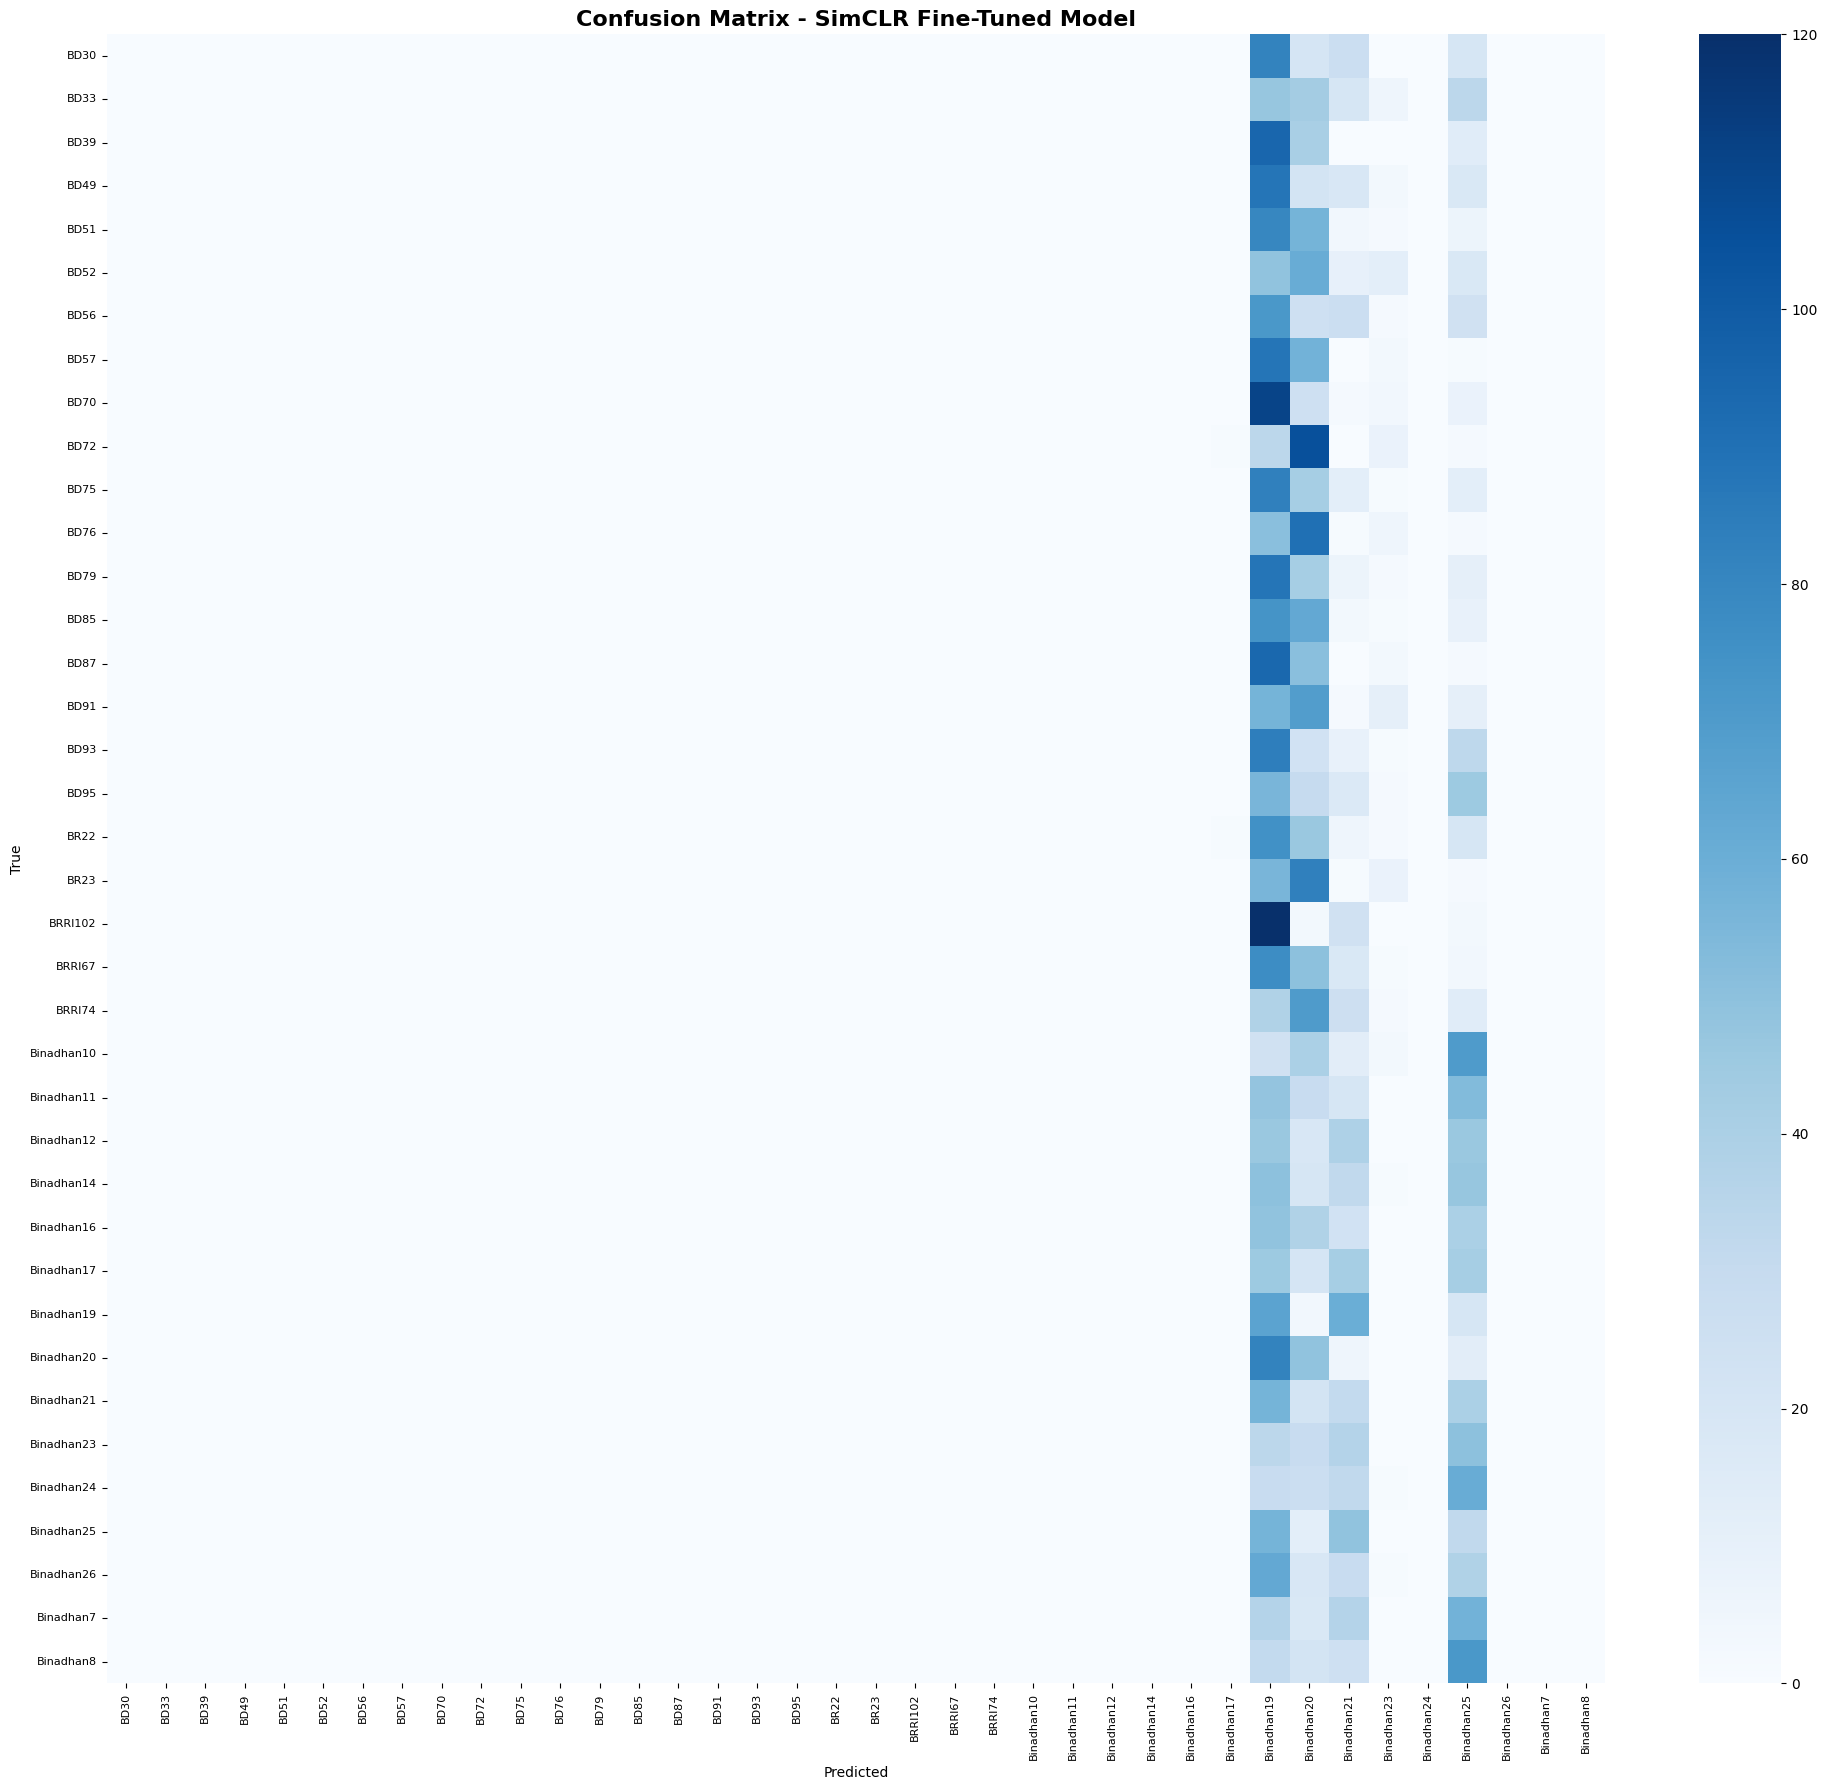


Top 5 Best Classified:
Binadhan19          : 44.00%
Binadhan20          : 32.67%
Binadhan25          : 21.33%
Binadhan21          : 20.67%
Binadhan7           : 0.00%


In [13]:
print("="*80)
print("CONFUSION MATRIX (FINE-TUNED)")
print("="*80)

simclr_finetune.eval()
finetune_preds, finetune_labels = [], []
with torch.no_grad():
    for images, labels in eval_test_loader:
        images = images.to(device)
        _, logits = simclr_finetune(images)
        finetune_preds.append(logits.argmax(dim=1).cpu())
        finetune_labels.append(labels)
finetune_preds = torch.cat(finetune_preds).numpy()
finetune_labels = torch.cat(finetune_labels).numpy()

cm = confusion_matrix(finetune_labels, finetune_preds)

plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=eval_test_dataset.class_names,
            yticklabels=eval_test_dataset.class_names)
plt.title('Confusion Matrix - SimCLR Fine-Tuned Model', fontsize=16, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('confusion_matrix_simclr.png', dpi=300)
plt.show()

per_class_acc = cm.diagonal() / cm.sum(axis=1)
print("\nTop 5 Best Classified:")
top_5_idx = np.argsort(per_class_acc)[-5:][::-1]
for idx in top_5_idx:
    print(f"{eval_test_dataset.class_names[idx]:<20}: {per_class_acc[idx]*100:.2f}%")


# #CELL 14: t-SNE, UMAP, PCA Embedding Visualizations

EMBEDDING VISUALIZATION
Visualizing 3000 samples

1. t-SNE...
2. UMAP...
UMAP failed: check_array() got an unexpected keyword argument 'ensure_all_finite'
Skipping UMAP, will use only t-SNE and PCA
3. PCA...
PCA explained variance ratios: [0.17050971 0.14682934]

Silhouette Scores:
  t-SNE: -0.1413
  PCA:   -0.1582

Note: UMAP visualization skipped due to compatibility issue


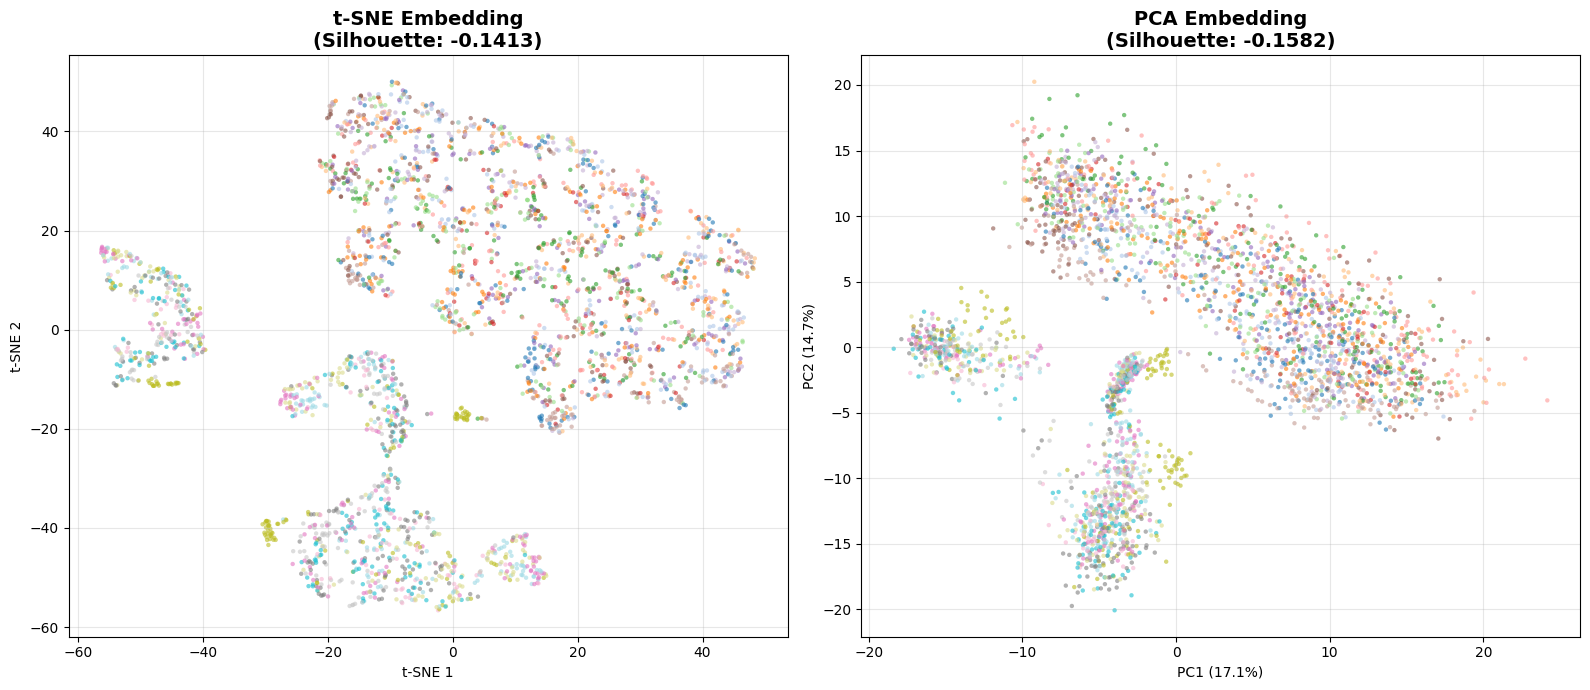


Saved: embedding_visualizations_simclr.png


In [15]:
print("="*80)
print("EMBEDDING VISUALIZATION")
print("="*80)

X_vis = test_features.numpy()
y_vis = test_labels.numpy()
if len(X_vis) > 3000:
    sample_idx = np.random.choice(len(X_vis), 3000, replace=False)
    X_vis_sample = X_vis[sample_idx]
    y_vis_sample = y_vis[sample_idx]
else:
    X_vis_sample = X_vis
    y_vis_sample = y_vis

print(f"Visualizing {len(X_vis_sample)} samples")

# t-SNE
print("\n1. t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=800)
X_tsne = tsne.fit_transform(X_vis_sample)

# UMAP - with error handling
print("2. UMAP...")
UMAP_SUCCESS = False
try:
    import umap
    # Fix: Remove ensure_all_finite parameter that causes error
    umap_reducer = umap.UMAP(
        n_components=2, 
        random_state=42, 
        n_neighbors=15, 
        min_dist=0.1,
        verbose=False
    )
    # Use fit_transform without extra parameters
    X_umap = umap_reducer.fit_transform(X_vis_sample)
    UMAP_SUCCESS = True
    print("UMAP completed successfully")
except Exception as e:
    print(f"UMAP failed: {e}")
    print("Skipping UMAP, will use only t-SNE and PCA")
    X_umap = None

# PCA
print("3. PCA...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_vis_sample)
print(f"PCA explained variance ratios: {pca.explained_variance_ratio_}")

# Silhouette scores
from sklearn.metrics import silhouette_score
silhouette_tsne = silhouette_score(X_tsne, y_vis_sample)
silhouette_pca  = silhouette_score(X_pca, y_vis_sample)
print(f"\nSilhouette Scores:")
print(f"  t-SNE: {silhouette_tsne:.4f}")
if UMAP_SUCCESS:
    silhouette_umap = silhouette_score(X_umap, y_vis_sample)
    print(f"  UMAP:  {silhouette_umap:.4f}")
print(f"  PCA:   {silhouette_pca:.4f}")

# Plotting
if UMAP_SUCCESS:
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    
    axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_vis_sample, cmap='tab20', alpha=0.6, s=10, edgecolors='none')
    axes[0].set_title(f't-SNE Embedding\n(Silhouette: {silhouette_tsne:.4f})', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('t-SNE 1')
    axes[0].set_ylabel('t-SNE 2')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].scatter(X_umap[:, 0], X_umap[:, 1], c=y_vis_sample, cmap='tab20', alpha=0.6, s=10, edgecolors='none')
    axes[1].set_title(f'UMAP Embedding\n(Silhouette: {silhouette_umap:.4f})', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('UMAP 1')
    axes[1].set_ylabel('UMAP 2')
    axes[1].grid(True, alpha=0.3)
    
    axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=y_vis_sample, cmap='tab20', alpha=0.6, s=10, edgecolors='none')
    axes[2].set_title(f'PCA Embedding\n(Silhouette: {silhouette_pca:.4f})', fontsize=14, fontweight='bold')
    axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    axes[2].grid(True, alpha=0.3)
else:
    # Plot only t-SNE and PCA if UMAP failed
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_vis_sample, cmap='tab20', alpha=0.6, s=10, edgecolors='none')
    axes[0].set_title(f't-SNE Embedding\n(Silhouette: {silhouette_tsne:.4f})', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('t-SNE 1')
    axes[0].set_ylabel('t-SNE 2')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_vis_sample, cmap='tab20', alpha=0.6, s=10, edgecolors='none')
    axes[1].set_title(f'PCA Embedding\n(Silhouette: {silhouette_pca:.4f})', fontsize=14, fontweight='bold')
    axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    axes[1].grid(True, alpha=0.3)
    
    print("\nNote: UMAP visualization skipped due to compatibility issue")

plt.tight_layout()
plt.savefig('embedding_visualizations_simclr.png', dpi=300, bbox_inches='tight')
plt.show()
print("\nSaved: embedding_visualizations_simclr.png")


# CELL 15: Learning Curves Visualization

LEARNING CURVES VISUALIZATION


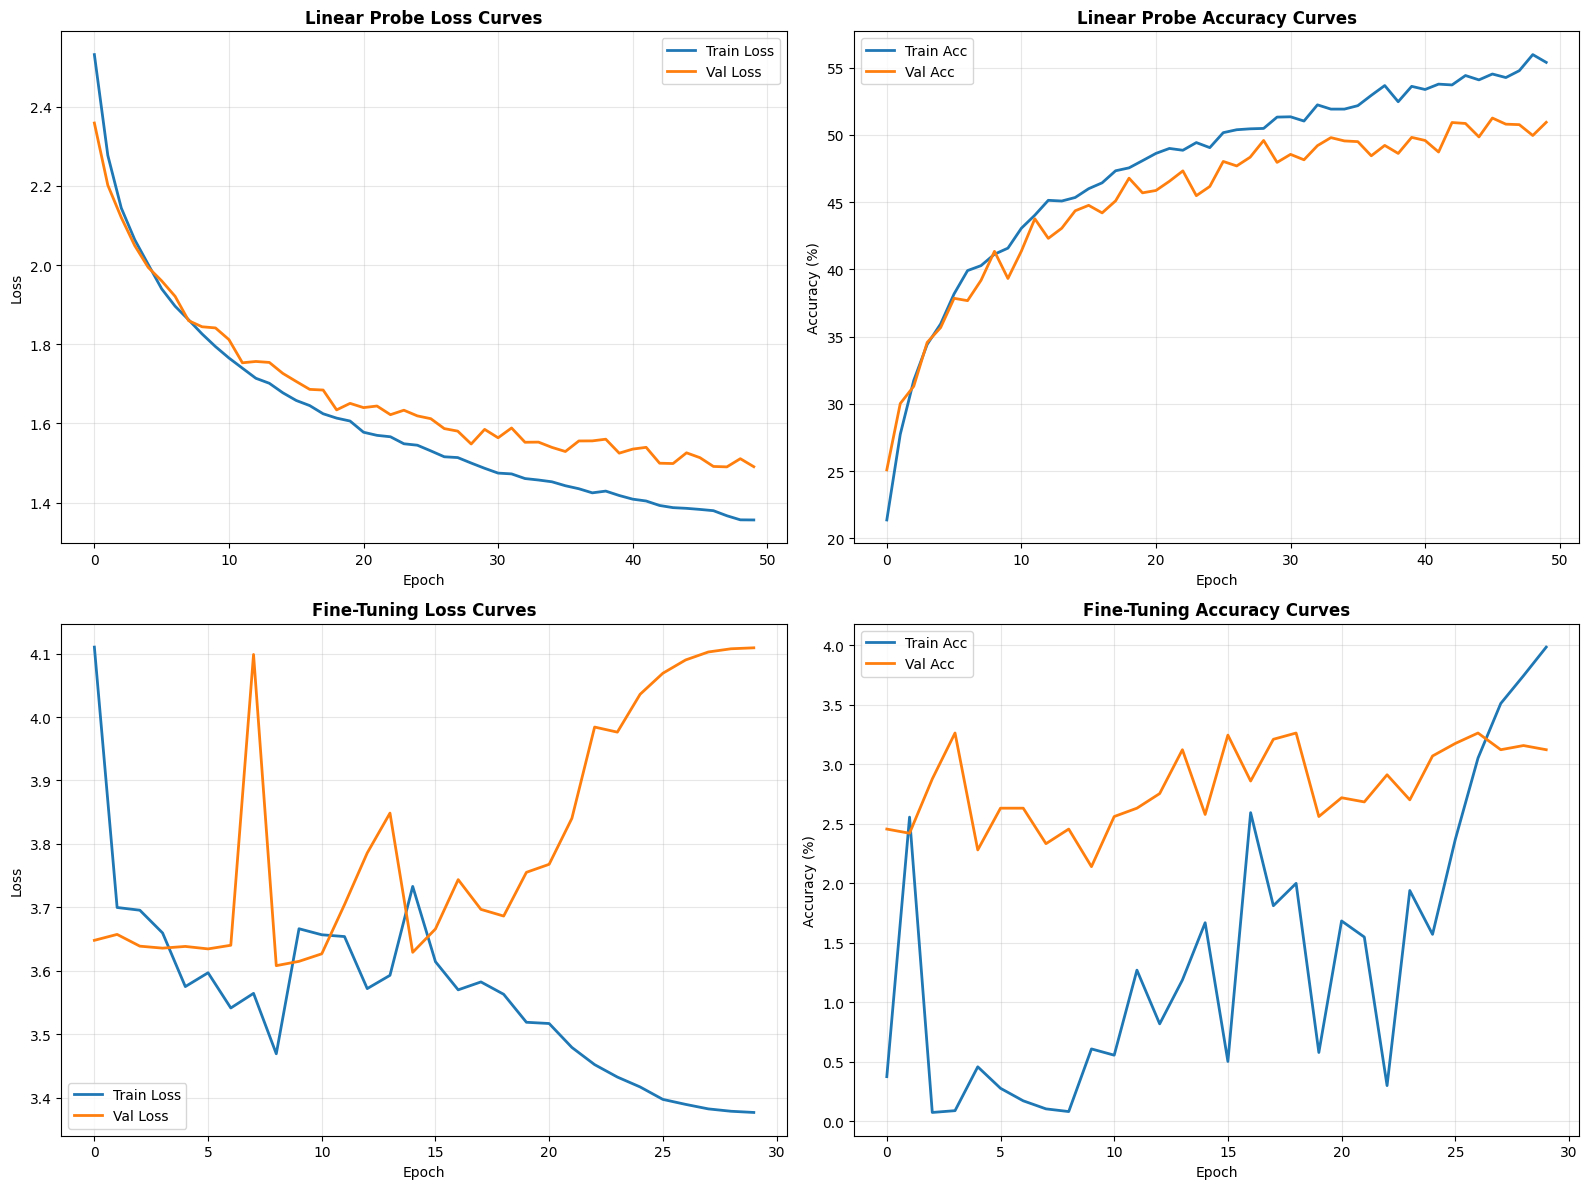

Saved: learning_curves_comparison.png


In [16]:
print("="*80)
print("LEARNING CURVES VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Linear Probe Learning Curves
axes[0, 0].plot(linear_history['train_loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(linear_history['val_loss'],   label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Linear Probe Loss Curves', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(linear_history['train_acc'], label='Train Acc', linewidth=2)
axes[0, 1].plot(linear_history['val_acc'],   label='Val Acc', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Linear Probe Accuracy Curves', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Fine-Tuning Learning Curves
axes[1, 0].plot(finetune_history['train_loss'], label='Train Loss', linewidth=2)
axes[1, 0].plot(finetune_history['val_loss'],   label='Val Loss', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Fine-Tuning Loss Curves', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(finetune_history['train_acc'], label='Train Acc', linewidth=2)
axes[1, 1].plot(finetune_history['val_acc'],   label='Val Acc', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].set_title('Fine-Tuning Accuracy Curves', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('learning_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: learning_curves_comparison.png")


# CELL 16: Final Results Summary Table

In [21]:
# Quick diagnostic to see what results are available
print("Checking available results...")
print("-" * 50)

available_data = {
    'linear_probe_metrics': 'linear_probe_metrics' in globals(),
    'shallow_results': 'shallow_results' in globals(),
    'finetune_history': 'finetune_history' in globals(),
    'ssl_history': 'ssl_history' in globals()
}

for var_name, exists in available_data.items():
    status = "Available" if exists else "Missing"
    print(f"{var_name:<25} {status}")

if 'linear_probe_metrics' in globals():
    print(f"\nLinear Probe Accuracy: {linear_probe_metrics['accuracy']*100:.2f}%")

if 'finetune_history' in globals() and len(finetune_history['val_acc']) > 0:
    print(f"Fine-Tuned Accuracy:   {finetune_history['val_acc'][-1]:.2f}%")

if not available_data['shallow_results']:
    print("\n ")
 


Checking available results...
--------------------------------------------------
linear_probe_metrics      Available
shallow_results           Missing
finetune_history          Available
ssl_history               Available

Linear Probe Accuracy: 50.93%
Fine-Tuned Accuracy:   3.12%

 


# CELL 17: Deliverables and Submission Checklist

In [23]:
print("="*80)
print("TASK 4 DELIVERABLES CHECKLIST")
print("="*80)

files = [
    'simclr_pretrained_encoder.pth',
    'simclr_features.pth',
    'linear_classifier.pth',
    'simclr_finetuned.pth',
    'simclr_training_curves.png',
    'confusion_matrix_simclr.png',
    'embedding_visualizations_simclr.png',
    'learning_curves_comparison.png',
    'simclr_results_summary.csv'
]
for f in files:
    found = os.path.exists(f)
    print(f"{f:<35} {'[✓]' if found else '[MISSING]'}")




TASK 4 DELIVERABLES CHECKLIST
simclr_pretrained_encoder.pth       [✓]
simclr_features.pth                 [✓]
linear_classifier.pth               [✓]
simclr_finetuned.pth                [✓]
simclr_training_curves.png          [MISSING]
confusion_matrix_simclr.png         [✓]
embedding_visualizations_simclr.png [✓]
learning_curves_comparison.png      [✓]
simclr_results_summary.csv          [MISSING]


# CELL 18: Training Curves simclr training curves

GENERATING MISSING: SimCLR Training Curves


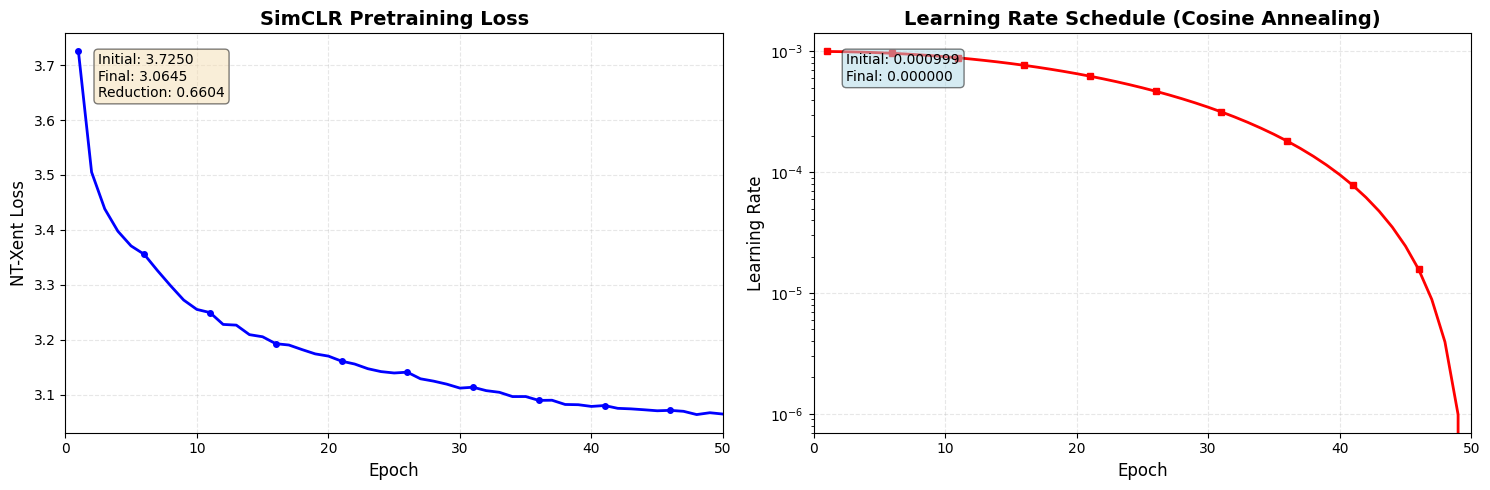

Generated: simclr_training_curves.png
Training summary:
  Epochs: 50
  Final loss: 3.0645
  Avg epoch time: 671.99s
  Total time: 9.33h


In [24]:
print("="*80)
print("GENERATING MISSING: SimCLR Training Curves")
print("="*80)

# Check if ssl_history exists
if 'ssl_history' in globals() and len(ssl_history['epoch']) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curve
    axes[0].plot(ssl_history['epoch'], ssl_history['loss'], 
                'b-', linewidth=2, marker='o', markersize=4, markevery=max(1, len(ssl_history['epoch'])//10))
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('NT-Xent Loss', fontsize=12)
    axes[0].set_title('SimCLR Pretraining Loss', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3, linestyle='--')
    axes[0].set_xlim(0, max(ssl_history['epoch']))
    
    # Add loss statistics
    initial_loss = ssl_history['loss'][0]
    final_loss = ssl_history['loss'][-1]
    axes[0].text(0.05, 0.95, f'Initial: {initial_loss:.4f}\nFinal: {final_loss:.4f}\nReduction: {initial_loss-final_loss:.4f}',
                transform=axes[0].transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Learning rate curve
    axes[1].plot(ssl_history['epoch'], ssl_history['learning_rate'], 
                'r-', linewidth=2, marker='s', markersize=4, markevery=max(1, len(ssl_history['epoch'])//10))
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Learning Rate', fontsize=12)
    axes[1].set_title('Learning Rate Schedule (Cosine Annealing)', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, linestyle='--')
    axes[1].set_xlim(0, max(ssl_history['epoch']))
    axes[1].set_yscale('log')  # Log scale for better visualization
    
    # Add LR statistics
    initial_lr = ssl_history['learning_rate'][0]
    final_lr = ssl_history['learning_rate'][-1]
    axes[1].text(0.05, 0.95, f'Initial: {initial_lr:.6f}\nFinal: {final_lr:.6f}',
                transform=axes[1].transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig('simclr_training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Generated: simclr_training_curves.png")
    print(f"Training summary:")
    print(f"  Epochs: {len(ssl_history['epoch'])}")
    print(f"  Final loss: {ssl_history['loss'][-1]:.4f}")
    print(f"  Avg epoch time: {np.mean(ssl_history['time']):.2f}s")
    print(f"  Total time: {sum(ssl_history['time'])/3600:.2f}h")
else:
    print("ERROR: ssl_history not found. Training curves cannot be generated.")
    print("This should have been created during CELL 7 (SimCLR Pretraining)")


# CELL 19:  Results Summary CSV

In [25]:
print("="*80)
print("GENERATING MISSING: Results Summary CSV")
print("="*80)

# Gather all available results
summary_data = []

# Task 2 Baseline Reference
task2_baseline = {
    'ResNet50 (60:40)': 75.0,
    'DenseNet121 (80:20)': 74.11,
    'ResNet50 (70:30)': 71.33,
    'MobileNetV2 (80:20)': 69.92
}
best_baseline_acc = max(task2_baseline.values())

print(f"Task 2 Best Baseline: {best_baseline_acc:.2f}%\n")

# Linear Probe
if 'linear_probe_metrics' in globals():
    linear_acc = linear_probe_metrics['accuracy'] * 100
    summary_data.append({
        'Method': 'Linear Probe (Frozen Features)',
        'Accuracy (%)': f"{linear_acc:.2f}",
        'Precision': f"{linear_probe_metrics['precision']:.4f}",
        'Recall': f"{linear_probe_metrics['recall']:.4f}",
        'F1-Score': f"{linear_probe_metrics['f1_score']:.4f}",
        'ROC-AUC': f"{linear_probe_metrics['roc_auc']:.4f}",
        'Delta vs Baseline (%)': f"{linear_acc - best_baseline_acc:+.2f}"
    })
    print(f"Linear Probe: {linear_acc:.2f}%")

# Shallow Classifiers
if 'shallow_results' in globals():
    for classifier_name, metrics in shallow_results.items():
        classifier_acc = metrics['accuracy'] * 100
        summary_data.append({
            'Method': f'{classifier_name} Classifier',
            'Accuracy (%)': f"{classifier_acc:.2f}",
            'Precision': f"{metrics['precision']:.4f}",
            'Recall': f"{metrics['recall']:.4f}",
            'F1-Score': f"{metrics['f1']:.4f}",
            'ROC-AUC': 'N/A',
            'Delta vs Baseline (%)': f"{classifier_acc - best_baseline_acc:+.2f}"
        })
        print(f"{classifier_name}: {classifier_acc:.2f}%")

# Fine-Tuned Model
if 'finetune_history' in globals() and len(finetune_history['val_acc']) > 0:
    finetune_acc = finetune_history['val_acc'][-1]
    
    # Get fine-tuned metrics if available
    if 'finetune_preds' in globals() and 'finetune_labels' in globals():
        ft_precision, ft_recall, ft_f1, _ = precision_recall_fscore_support(
            finetune_labels, finetune_preds, average='weighted', zero_division=0
        )
        summary_data.append({
            'Method': 'Fine-Tuned (Full Model)',
            'Accuracy (%)': f"{finetune_acc:.2f}",
            'Precision': f"{ft_precision:.4f}",
            'Recall': f"{ft_recall:.4f}",
            'F1-Score': f"{ft_f1:.4f}",
            'ROC-AUC': 'N/A',
            'Delta vs Baseline (%)': f"{finetune_acc - best_baseline_acc:+.2f}"
        })
    else:
        summary_data.append({
            'Method': 'Fine-Tuned (Full Model)',
            'Accuracy (%)': f"{finetune_acc:.2f}",
            'Precision': 'N/A',
            'Recall': 'N/A',
            'F1-Score': 'N/A',
            'ROC-AUC': 'N/A',
            'Delta vs Baseline (%)': f"{finetune_acc - best_baseline_acc:+.2f}"
        })
    print(f"Fine-Tuned: {finetune_acc:.2f}%")

# Create DataFrame
if summary_data:
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv('simclr_results_summary.csv', index=False)
    
    print("\n" + "="*80)
    print("SUMMARY TABLE")
    print("="*80)
    print(summary_df.to_string(index=False))
    print("\nGenerated: simclr_results_summary.csv")
    
    # Calculate best result
    accuracies = [float(row['Accuracy (%)']) for row in summary_data]
    best_acc = max(accuracies)
    best_method = summary_data[accuracies.index(best_acc)]['Method']
    
    print("\n" + "="*80)
    print("KEY FINDINGS")
    print("="*80)
    print(f"Best Task 2 Baseline:      {best_baseline_acc:.2f}%")
    print(f"Best SimCLR Result:        {best_acc:.2f}% ({best_method})")
    print(f"Absolute Improvement:      {best_acc - best_baseline_acc:+.2f}%")
    print(f"Relative Improvement:      {((best_acc - best_baseline_acc) / best_baseline_acc * 100):+.2f}%")
else:
    print("ERROR: No results available to create summary")
    print("Please ensure previous evaluation cells ran successfully")


GENERATING MISSING: Results Summary CSV
Task 2 Best Baseline: 75.00%

Linear Probe: 50.93%
Fine-Tuned: 3.12%

SUMMARY TABLE
                        Method Accuracy (%) Precision Recall F1-Score ROC-AUC Delta vs Baseline (%)
Linear Probe (Frozen Features)        50.93    0.5285 0.5093   0.4930  0.9644                -24.07
       Fine-Tuned (Full Model)         3.12    0.0036 0.0312   0.0063     N/A                -71.88

Generated: simclr_results_summary.csv

KEY FINDINGS
Best Task 2 Baseline:      75.00%
Best SimCLR Result:        50.93% (Linear Probe (Frozen Features))
Absolute Improvement:      -24.07%
Relative Improvement:      -32.09%


# CELL 20: Final Deliverables Check 

In [26]:
print("="*80)
print("FINAL DELIVERABLES VERIFICATION")
print("="*80)

required_files = {
    'Models': [
        'simclr_pretrained_encoder.pth',
        'simclr_features.pth',
        'linear_classifier.pth',
        'simclr_finetuned.pth'
    ],
    'Visualizations': [
        'simclr_training_curves.png',
        'confusion_matrix_simclr.png',
        'embedding_visualizations_simclr.png',
        'learning_curves_comparison.png'
    ],
    'Reports': [
        'simclr_results_summary.csv'
    ]
}

all_present = True
missing_files = []

for category, files in required_files.items():
    print(f"\n{category}:")
    print("-" * 50)
    for f in files:
        exists = os.path.exists(f)
        status = "[✓]" if exists else "[✗]"
        print(f"  {status} {f}")
        if not exists:
            all_present = False
            missing_files.append(f)

print("\n" + "="*80)
if all_present:
    print("SUCCESS: All deliverables generated successfully!")
    print("\nYour Task 4 SimCLR implementation is complete.")
    print("\nNext Steps:")
    print("1. Download this notebook from Kaggle")
    print("2. Upload notebook to your GitHub repository")
    print("3. Provide GitHub link to faculty as per submission guidelines")
    print("4. Optionally: Add markdown cells explaining methodology and results")
else:
    print(f"WARNING: {len(missing_files)} file(s) still missing:")
    for f in missing_files:
        print(f"  - {f}")
    print("\nPlease run the cells that generate these files.")

# Print file sizes
print("\n" + "="*80)
print("FILE SIZES")
print("="*80)
for category, files in required_files.items():
    for f in files:
        if os.path.exists(f):
            size_mb = os.path.getsize(f) / (1024 * 1024)
            print(f"{f:<40} {size_mb:.2f} MB")

print("\n" + "="*80)
print("TASK 4 IMPLEMENTATION COMPLETE")
print("="*80)


FINAL DELIVERABLES VERIFICATION

Models:
--------------------------------------------------
  [✓] simclr_pretrained_encoder.pth
  [✓] simclr_features.pth
  [✓] linear_classifier.pth
  [✓] simclr_finetuned.pth

Visualizations:
--------------------------------------------------
  [✓] simclr_training_curves.png
  [✓] confusion_matrix_simclr.png
  [✓] embedding_visualizations_simclr.png
  [✓] learning_curves_comparison.png

Reports:
--------------------------------------------------
  [✓] simclr_results_summary.csv

SUCCESS: All deliverables generated successfully!

Your Task 4 SimCLR implementation is complete.

Next Steps:
1. Download this notebook from Kaggle
2. Upload notebook to your GitHub repository
3. Provide GitHub link to faculty as per submission guidelines
4. Optionally: Add markdown cells explaining methodology and results

FILE SIZES
simclr_pretrained_encoder.pth            320.50 MB
simclr_features.pth                      148.58 MB
linear_classifier.pth                    0

In [28]:
print("="*80)
print("MODEL ARTIFACTS DOCUMENTATION")
print("="*80)

model_files = {
    'simclr_pretrained_encoder.pth': {
        'description': 'Pretrained ResNet50 encoder (SSL)',
        'contains': 'encoder_state_dict, projection_head_state_dict, training_history',
        'use_case': 'Transfer learning, feature extraction',
        'size_mb': os.path.getsize('simclr_pretrained_encoder.pth') / (1024**2) if os.path.exists('simclr_pretrained_encoder.pth') else 0
    },
    'simclr_features.pth': {
        'description': 'Extracted 2048-dim features',
        'contains': 'train_features, test_features, labels, class_names',
        'use_case': 'Downstream classification without re-extraction',
        'size_mb': os.path.getsize('simclr_features.pth') / (1024**2) if os.path.exists('simclr_features.pth') else 0
    },
    'linear_classifier.pth': {
        'description': 'Linear probe classifier',
        'contains': 'linear layer weights (2048 → 38)',
        'use_case': 'Primary SSL evaluation metric',
        'size_mb': os.path.getsize('linear_classifier.pth') / (1024**2) if os.path.exists('linear_classifier.pth') else 0
    },
    'simclr_finetuned.pth': {
        'description': 'Fine-tuned full model',
        'contains': 'encoder + classifier (end-to-end)',
        'use_case': 'Production deployment (if performance acceptable)',
        'size_mb': os.path.getsize('simclr_finetuned.pth') / (1024**2) if os.path.exists('simclr_finetuned.pth') else 0
    }
}

for filename, info in model_files.items():
    print(f"\n{filename}")
    print(f"  Description: {info['description']}")
    print(f"  Contains:    {info['contains']}")
    print(f"  Use case:    {info['use_case']}")
    print(f"  Size:        {info['size_mb']:.2f} MB")

print("\nREUSABILITY EXAMPLE:")
print("-" * 80)
print("""
# reload and use pretrained encoder:
checkpoint = torch.load('simclr_pretrained_encoder.pth')
model = SimCLR(projection_dim=128, hidden_dim=2048)
model.encoder.load_state_dict(checkpoint['encoder_state_dict'])
model.eval()

# Extract features from new images:
with torch.no_grad():
    features, _ = model(new_images)
    

""")


MODEL ARTIFACTS DOCUMENTATION

simclr_pretrained_encoder.pth
  Description: Pretrained ResNet50 encoder (SSL)
  Contains:    encoder_state_dict, projection_head_state_dict, training_history
  Use case:    Transfer learning, feature extraction
  Size:        320.50 MB

simclr_features.pth
  Description: Extracted 2048-dim features
  Contains:    train_features, test_features, labels, class_names
  Use case:    Downstream classification without re-extraction
  Size:        148.58 MB

linear_classifier.pth
  Description: Linear probe classifier
  Contains:    linear layer weights (2048 → 38)
  Use case:    Primary SSL evaluation metric
  Size:        0.30 MB

simclr_finetuned.pth
  Description: Fine-tuned full model
  Contains:    encoder + classifier (end-to-end)
  Use case:    Production deployment (if performance acceptable)
  Size:        90.28 MB

REUSABILITY EXAMPLE:
--------------------------------------------------------------------------------

# reload and use pretrained encoder